In [3]:
# # Colab에서 실행할때만 실행

# import json
# import os

# KAGGLE_UPLOAD = False

# if KAGGLE_UPLOAD:
#     # /content/ 폴더에 kaggle.json을 업로드 (매번 colab노트북 생성시 반복)
#     from google.colab import files
#     files.upload()
# else:
#     kaggle_username = 'seungminl'
#     from google.colab import userdata
#     kaggle_key = userdata.get(kaggle_username)

# def create_kaggle_json(username, key, file_path):
#     # 데이터 생성
#     kaggle_data = {
#         "username": username,
#         "key": key
#     }

#     # JSON 파일로 저장
#     with open(file_path, 'w') as json_file:
#         json.dump(kaggle_data, json_file)

#     print(f"kaggle.json 파일이 '{os.path.abspath(file_path)}' 경로에 생성되었습니다.")

# # kaggle.json 파일 생성 함수 호출
# if KAGGLE_UPLOAD==False:
#     # 사용자 정보 입력
#     key = kaggle_key  # 여기에 key값을 입력하세요
#     filename = 'kaggle.json'
#     create_kaggle_json(kaggle_username, key, filename)

# !cat kaggle.json

# os.makedirs('/root/.kaggle', exist_ok=True)
# path = os.getcwd()

# # 파일을 복사하는데, 이미 복사된 경우 복사하지 않는다.
# if not os.path.exists(os.path.join('/root/.kaggle','kaggle.json')):
#     src = os.path.join(path,'kaggle.json')
#     dst = os.path.join('/root/.kaggle', 'kaggle.json')
#     shutil.copy(src,dst)
#     print('파일 복사 완료')

# !cat /root/.kaggle/kaggle.json

# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d puneet6060/intel-image-classification

# !unzip -qq intel-image-classification.zip -d /content/dataset/

# !ls dataset

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision
from torchvision import datasets
import os
from pathlib import Path
import random
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms , datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm 
from timeit import default_timer as timer
from torch.autograd import Variable
import warnings
import zipfile
import shutil
warnings.filterwarnings('ignore')

In [5]:
print(f'The version of torch is : {torch.__version__}\nThe version of torchvision is : {torchvision.__version__}')

The version of torch is : 2.4.1
The version of torchvision is : 0.19.1


In [6]:
!nvidia-smi

Tue Oct  1 13:50:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              5W /   89W |     690MiB /   8188MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
if not os.path.exists('intel-image-classification.zip'):
	!pip install kaggle --upgrade
	!pip show kaggle

	!kaggle config view

	!kaggle datasets download -d puneet6060/intel-image-classification

In [9]:
# dataset에다가 압축 풀기
path = os.getcwd()

if not os.path.exists(os.path.join(path, 'data')):
	with zipfile.ZipFile(os.path.join(path, 'intel-image-classification.zip'), 'r') as existing_zip:
		existing_zip.extractall(os.path.join(path, 'data'))

In [10]:
# train데이터를 8:2로 나눠서 train:valid
# pred데이터를 test데이터로 사용

data_path = 'data'
train_path = os.path.join(data_path, 'seg_train', 'seg_train')
test_path = os.path.join(data_path, 'seg_pred', 'seg_pred')

In [11]:
def check_diractory(directory_path):
                                 
    for dirpath , dirname , filename in os.walk(directory_path):
        print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")
        

In [12]:
folder_list = os.listdir(train_path)
print('TrainDataSize')
check_diractory(train_path)

TrainDataSize
There are 6 directories and 0 images in 'data\seg_train\seg_train'.
There are 0 directories and 1753 images in 'data\seg_train\seg_train\buildings'.
There are 0 directories and 1817 images in 'data\seg_train\seg_train\forest'.
There are 0 directories and 1924 images in 'data\seg_train\seg_train\glacier'.
There are 0 directories and 2010 images in 'data\seg_train\seg_train\mountain'.
There are 0 directories and 1820 images in 'data\seg_train\seg_train\sea'.
There are 0 directories and 1906 images in 'data\seg_train\seg_train\street'.


In [13]:
train_ratio = 0.8
valid_ratio = 0.2

# validPath를 지정
valid_path = os.path.join(data_path, 'seg_valid/')

# 모든 폴더 8:2 나누는 것을 구현

# validCount만큼 validPath에 폴더를 생성하고, 클래스 6개의 하위 폴더를 생성
# 그 폴더안에 502, 480, 476, 438, 454, 454 갯수만큼 복사를 해야하는데, 현재 fileList를 shuffle하고
# 그 안에서 랜덤하게 502, 480, 476, 438, 454, 454 갯수만큼 골라서 shutil.move(oldPath, newPath)로 이동
if not os.path.exists(valid_path):
  # validPath 폴더를 생성
  os.makedirs(valid_path, exist_ok=True)

  folder_list = os.listdir(train_path)
  for folder in folder_list:
    current_dir = os.path.join(train_path, folder)

    # 현재 폴더의 파일 목록, 갯수
    file_list = os.listdir(current_dir)
    dataCount = len(file_list)
    validCount = int(dataCount * valid_ratio)

    # validPath의 클래스 폴더를 생성
    os.makedirs(os.path.join(valid_path, folder), exist_ok=True)

    # 파일 리스트에서 랜덤하게 validCount만큼 선택해서 validList 생성
    validList = random.sample(file_list, validCount)
    for validFile in validList:
      oldPath = os.path.join(current_dir, validFile)
      newPath = os.path.join(valid_path, folder, validFile)
      shutil.move(oldPath, newPath)

In [14]:
folder_list = os.listdir(valid_path)
print('ValidDataSize')
check_diractory(valid_path)

ValidDataSize
There are 6 directories and 0 images in 'data\seg_valid/'.
There are 0 directories and 438 images in 'data\seg_valid/buildings'.
There are 0 directories and 454 images in 'data\seg_valid/forest'.
There are 0 directories and 480 images in 'data\seg_valid/glacier'.
There are 0 directories and 502 images in 'data\seg_valid/mountain'.
There are 0 directories and 454 images in 'data\seg_valid/sea'.
There are 0 directories and 476 images in 'data\seg_valid/street'.


In [15]:
# 파일 경로와 레이블을 생성하는 함수
def get_file_paths_and_labels(dataset_dir, classes):
    file_paths = []
    labels = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)

    return file_paths, labels

In [16]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# train dataset
folder_list = os.listdir(train_path)
train_file_path, train_file_label = get_file_paths_and_labels(train_path, classes)

print('Train Data Set :', len(train_file_path))
print('Train Label Set :', len(train_file_label))

# valid dataset
folder_list = os.listdir(valid_path)
valid_file_path, valid_file_label = get_file_paths_and_labels(valid_path, classes)

print('Valid Data Set :', len(valid_file_path))
print('Valid Label Set :', len(valid_file_label))

Train Data Set : 11230
Train Label Set : 11230
Valid Data Set : 2804
Valid Label Set : 2804


In [17]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
# 이미지 전처리 설정
train_transforms = transforms.Compose([
    transforms.Resize(size=(150 , 150)) ,
    transforms.ColorJitter(0.4,0.5,0.5,0.2),
    transforms.RandomHorizontalFlip(p=0.5) , 
    transforms.RandomCrop(size=(150,150)),  
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])


test_transforms = transforms.Compose([
    transforms.Resize((150, 150)), 
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.073171..2.902439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6714492..1.1425157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.073171..2.902439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5758011..0.7790532].


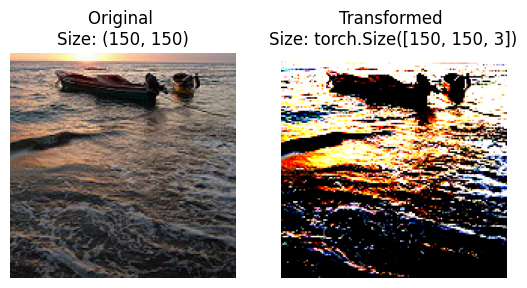

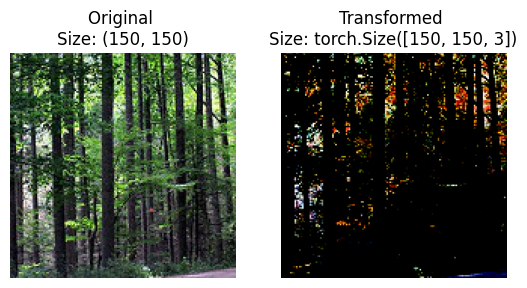

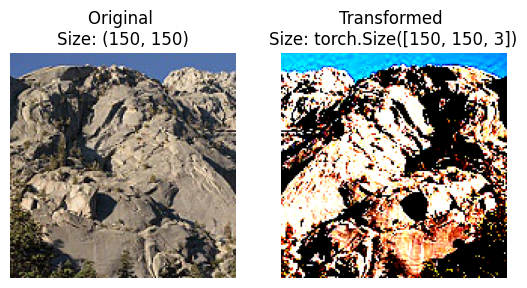

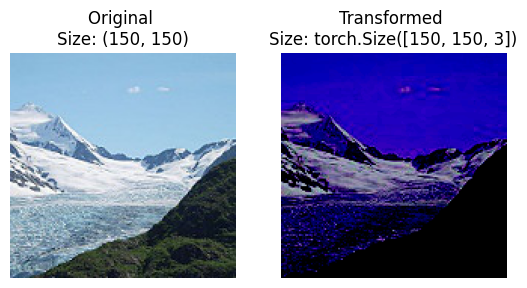

In [19]:
def show_transformed_images(path, transform , number=4 ,seed = 42):
    
    random.seed = seed
    random_image = random.sample(path , number)
    for path in random_image:
        with Image.open(path) as f :
            fig , ax = plt.subplots(1,2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
    
    plt.show()
            
show_transformed_images(path=train_file_path , 
                        transform=train_transforms, 
                        number=4)

In [20]:
# 데이터셋 준비
train_dataset = CustomDataset(train_file_path, train_file_label, transform=train_transforms)
valid_dataset = CustomDataset(valid_file_path, valid_file_label, transform=train_transforms)

# 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [21]:
img , label = next(iter(train_loader))
# img
print(f'The shape is : {img.shape} [batch-size , color-channels , height , width]')
print(f'The label shape is : {label.shape}')

The shape is : torch.Size([32, 3, 150, 150]) [batch-size , color-channels , height , width]
The label shape is : torch.Size([32])


In [22]:
Model = torchvision.models.wide_resnet50_2(pretrained=True)

for param in Model.parameters():
    param.required_grad = False
    
number_feature = Model.fc.in_features
Model.fc = nn.Linear(in_features=number_feature , out_features=len(train_dataset.labels) , bias=True)

In [23]:
Model.fc
Model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [24]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model.parameters() , lr = 0.01)
schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[3 , 6 ] ,
                                                        gamma=0.055)

In [25]:
 
try :
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary   
summary(Model, input_size=[1, 3, 64, 64] )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 11230]                --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 256, 16, 16]          --
│    └─Bottleneck: 2-1                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          8,192
│    │    └─BatchNorm2d: 3-2             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-3                    [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-4                  [1, 128, 16, 16]          147,456
│    │    └─BatchNorm2d: 3-5             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-6                    [1, 128, 16, 16]          --
│

In [26]:
st_time = timer()
epochs = 1

valid_loss_min = np.Inf
Valid_loss = []
Train_loss = []

for epoch in range(1,epochs+1):
	train_loss  = 0.0
	valid_loss  = 0.0

    #train
	Model.train()

	train_total = len(train_loader)
    
	trainStr = f'Epoch {epoch:2d}/{epochs} \033[34m' + 'Train ' + '\033[0m'
	with tqdm(total=train_total, desc=trainStr) as t:
		for batch , (X, y) in enumerate(train_loader):
			X, y = X.to(device), y.to(device)
			optimizer.zero_grad()
			y_pred = Model(X)
			loss = loss_function(y_pred, y)
			loss.backward()
			optimizer.step()
			train_loss += loss.item()*X.size(0)
			t.set_postfix({'loss' : loss.item()})
			t.update(1)
            
    #valid
	Model.eval()

	valid_total = len(valid_loader)
    
	validStr = f'Epoch {epoch+1:2d}/{epochs} \033[32m' + 'Valid ' + '\033[0m'
	with tqdm(total=valid_total, desc=validStr) as v:
		for batch , (X, y) in enumerate(valid_loader):
			X, y = X.to(device), y.to(device)
			y_pred = Model(X)
			loss = loss_function(y_pred, y)
			valid_loss += loss.item()*X.size(0)
            
			v.set_postfix({'loss' : loss.item()})
			v.update(1)
    
	train_loss = train_loss/len(train_loader.dataset)
	valid_loss = valid_loss/len(valid_loader.dataset)
	Valid_loss.append(valid_loss)
	Train_loss.append(train_loss)
    
	schedul_learning.step()
	end_time = timer()
    
	print(f'Epoch : {epoch+1}/{epochs} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

	if valid_loss <= valid_loss_min:
		print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
		torch.save(Model.state_dict(), 'model.pt')
		valid_loss_min = valid_loss
	
	print('Learning Rate : {:.4f}'.format(optimizer.state_dict()['param_groups'][0]['lr']))
	print('\nTime : {:.2f}'.format(end_time - st_time))
	print('----------------------------------')



Epoch  1/1 Train :   0%|          | 0/351 [00:00<?, ?it/s]

Epoch  2/1 Valid :   0%|          | 0/88 [00:00<?, ?it/s]

Epoch : 2/1 	Training Loss: 0.643826 	Validation Loss: 0.226725
Validation loss decreased (inf --> 0.226725).  Saving model ...
Learning Rate : 0.0100

Time : 121.01
----------------------------------


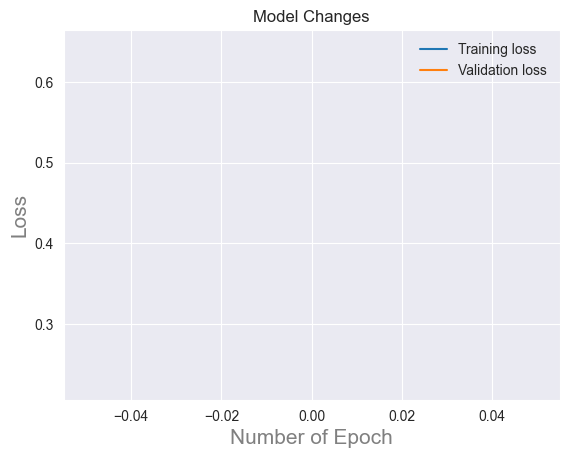

In [27]:
sns.set_style('darkgrid')
plt.plot(Train_loss, label='Training loss')
plt.plot(Valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Number of Epoch' , size = 15 , c = 'gray')
plt.ylabel('Loss' , size = 15 , c='gray')
plt.title('Model Changes')
plt.show()

In [28]:
Model.load_state_dict(torch.load('model.pt'))
Model.eval()
Model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7234043..2.3877552].


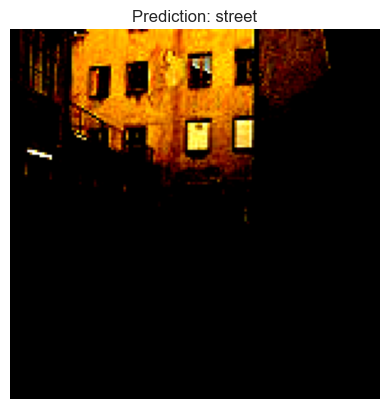

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7234043..2.531915].


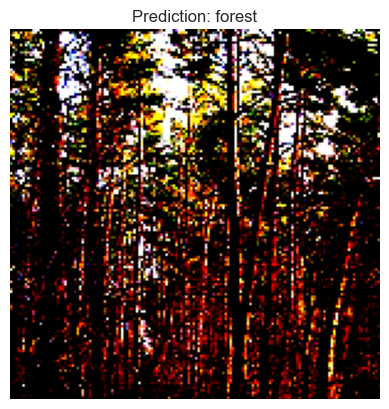

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7234043..2.531915].


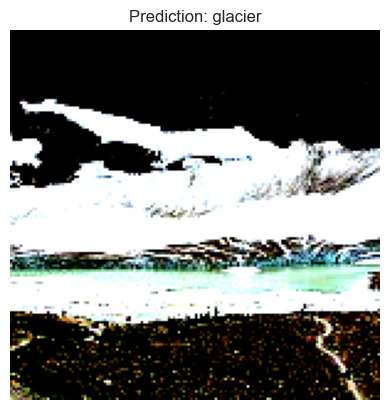

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7234043..1.8477263].


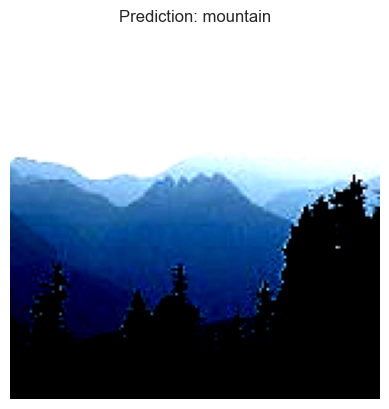

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7234043..2.531915].


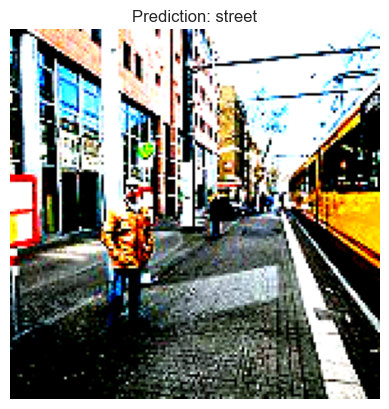

In [33]:
# seg_pred 데이터셋을 이용하여 예측하기
test_path = os.path.join(data_path, 'seg_pred/seg_pred')
test_list = os.listdir(test_path)

for i in range(5):
	random_image = random.choice(test_list)
	image_path = os.path.join(test_path, random_image)
	image = Image.open(image_path).convert("RGB")
	image = test_transforms(image).unsqueeze(0).to(device)
	
	with torch.no_grad():
		output = Model(image)
		_, pred = torch.max(output, 1)
		
	plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
	plt.axis('off')
	plt.title(f'Prediction: {classes[pred]}')
	plt.show()